## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Load and Preview Dataset

In [3]:
df = pd.read_csv('../data/cleaned_diet_data_snacks.csv')
df

,date,snack_calories
0,2018-07-30,243.75
1,2018-07-31,325.00
2,2018-08-01,312.50
3,2018-08-02,231.25
4,2018-08-03,362.50
...,...,...
138,2018-12-15,718.75
139,2018-12-16,368.75
140,2018-12-17,243.75
141,2018-12-18,237.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            143 non-null    object 
 1   snack_calories  143 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [5]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

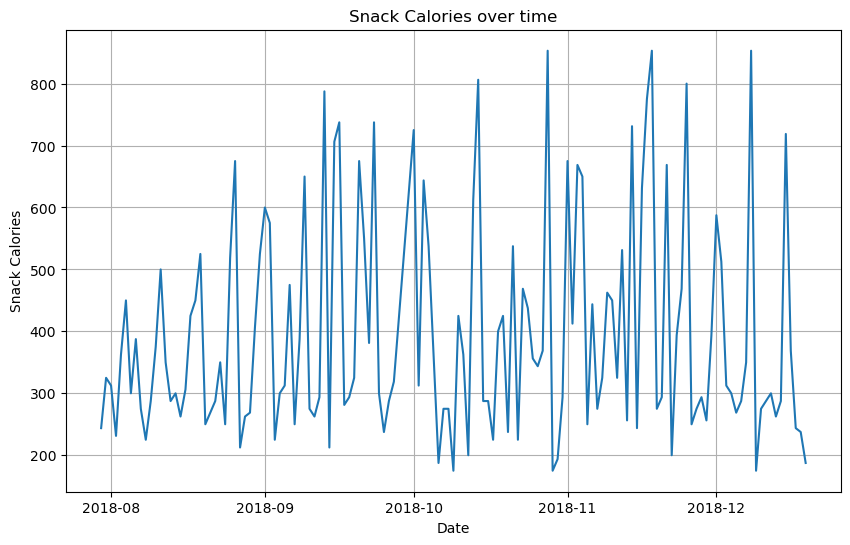

In [6]:
# extract the time_step and snack_calories columns
time_step = df['date'].values  
snack_calories = df['snack_calories'].values  

# convert to numpy arrays
time = np.array(time_step)
series = np.array(snack_calories)

# preview the data
plot_series(time, series, title='Snack Calories over time', xlabel='Date', ylabel='Snack Calories')

## Split Dataset

In [7]:
# Define the split time
split_time = int(df.shape[0] * 0.9)

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepared Features and Labels

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [9]:
# Parameters
window_size = 7
batch_size = 32
shuffle_buffer_size = 143

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [10]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                        strides=1,
                        activation="relu",
                        padding='causal'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 bidirectional (Bidirectiona  (None, 7, 256)           197632    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 1

## Tune the Learning Rate

In [11]:
# Get initial weights
init_weights = model.get_weights()

In [12]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
4/4 [==============================] - 19s 842ms/step - loss: 422.1152 - lr: 1.0000e-08
Epoch 2/100
4/4 [==============================] - 0s 57ms/step - loss: 421.7274 - lr: 1.1220e-08
Epoch 3/100
4/4 [==============================] - 0s 46ms/step - loss: 421.0399 - lr: 1.2589e-08
Epoch 4/100
4/4 [==============================] - 0s 58ms/step - loss: 420.1106 - lr: 1.4125e-08
Epoch 5/100
4/4 [==============================] - 0s 102ms/step - loss: 418.9557 - lr: 1.5849e-08
Epoch 6/100
4/4 [==============================] - 0s 54ms/step - loss: 417.5597 - lr: 1.7783e-08
Epoch 7/100
4/4 [==============================] - 0s 46ms/step - loss: 415.8544 - lr: 1.9953e-08
Epoch 8/100
4/4 [==============================] - 0s 59ms/step - loss: 413.7843 - lr: 2.2387e-08
Epoch 9/100
4/4 [==============================] - 0s 62ms/step - loss: 411.3498 - lr: 2.5119e-08
Epoch 10/100
4/4 [==============================] - 0s 58ms/step - loss: 408.4611 - lr: 2.8184e-08
Epoch 11/100
4/4

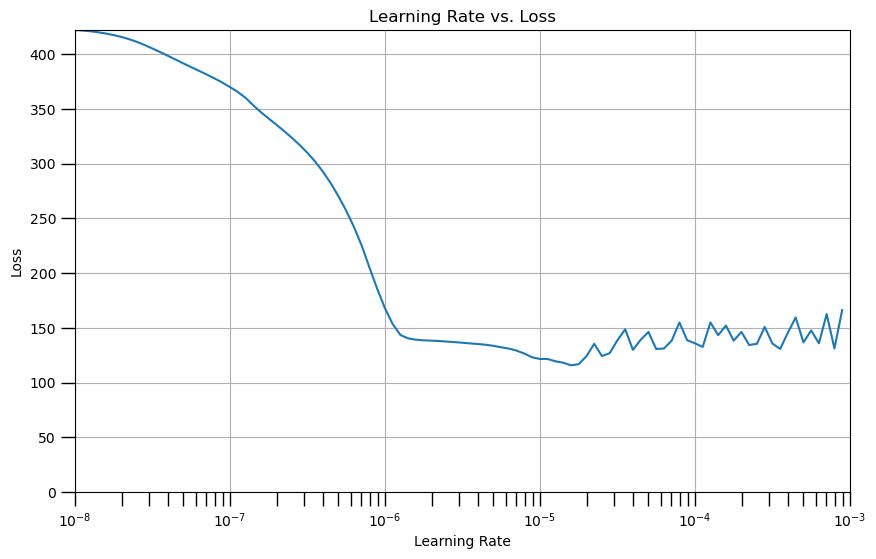

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, max(history.history["loss"])])

# Set the title and labels
plt.title('Learning Rate vs. Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

# Show the plot
plt.show()

## Train the Model

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [15]:
# Set the learning rate
learning_rate = 8e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [16]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100


4/4 [==============================] - 11s 40ms/step - loss: 392.0354 - mae: 392.5354
Epoch 2/100
4/4 [==============================] - 0s 34ms/step - loss: 302.5326 - mae: 303.0326
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 202.8850 - mae: 203.3850
Epoch 4/100
4/4 [==============================] - 0s 35ms/step - loss: 146.0635 - mae: 146.5635
Epoch 5/100
4/4 [==============================] - 0s 30ms/step - loss: 152.3208 - mae: 152.8208
Epoch 6/100
4/4 [==============================] - 0s 32ms/step - loss: 143.2301 - mae: 143.7301
Epoch 7/100
4/4 [==============================] - 0s 30ms/step - loss: 140.8714 - mae: 141.3714
Epoch 8/100
4/4 [==============================] - 0s 29ms/step - loss: 139.0557 - mae: 139.5557
Epoch 9/100
4/4 [==============================] - 0s 32ms/step - loss: 137.4026 - mae: 137.9026
Epoch 10/100
4/4 [==============================] - 0s 30ms/step - loss: 136.2707 - mae: 136.7707
Epoch 11/100
4/4 [======================

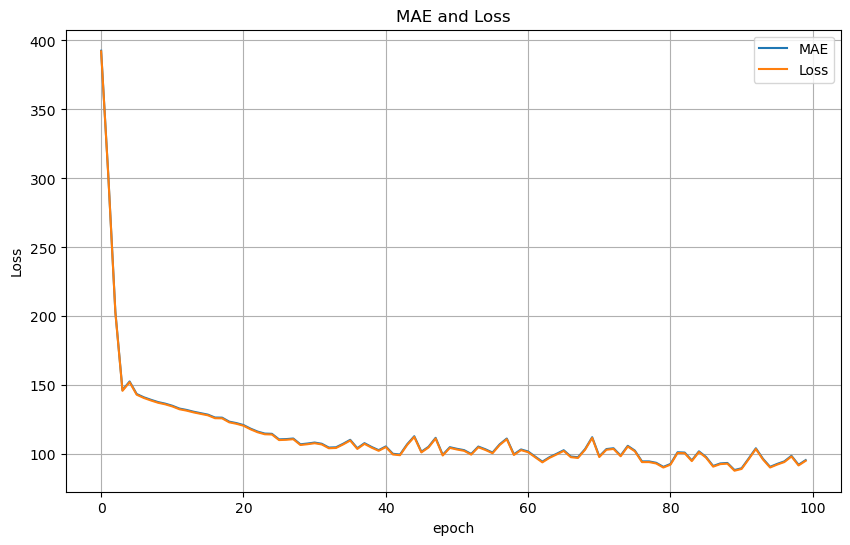

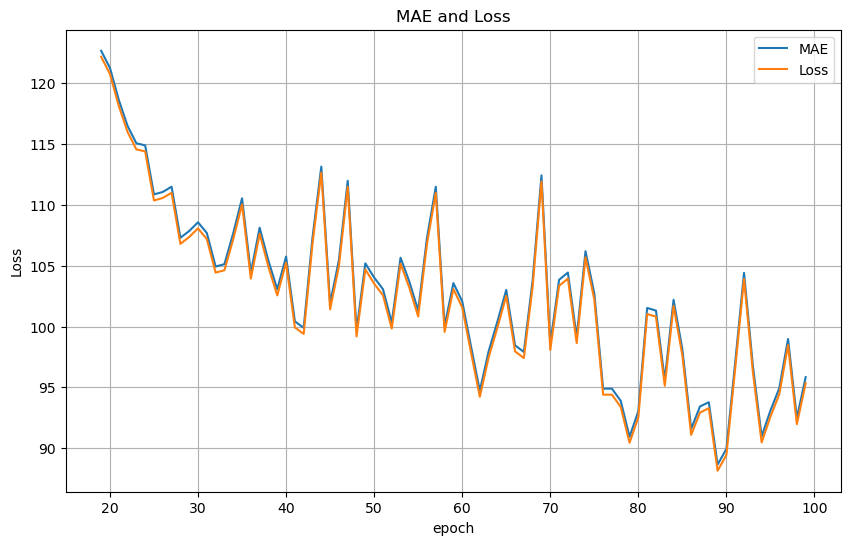

In [17]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

In [18]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

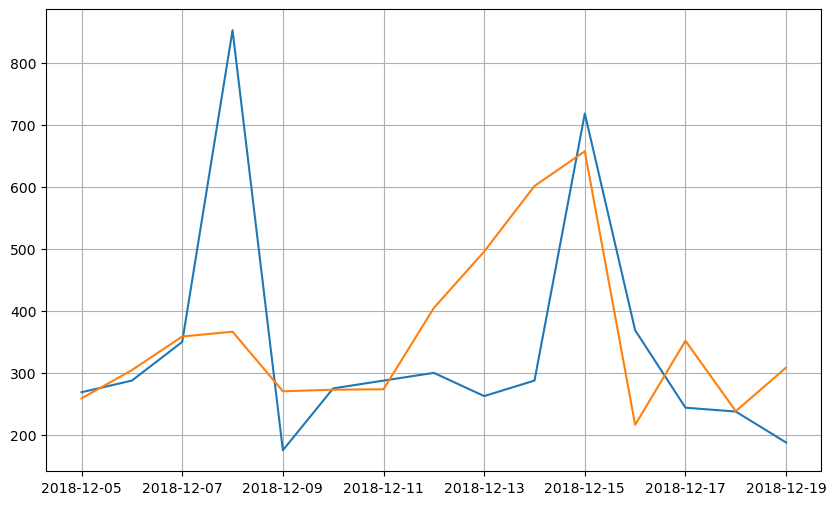

In [19]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [20]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

115.296036
